In [1]:
!pip install -q biopython

     |████████████████████████████████| 2.3MB 5.7MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -r '/content/drive/My Drive/dna_nn' .
!ls dna_nn

download.py  load.py


In [4]:
import gc

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

from dna_nn.load import encode, encoded_shape, gen_from_arrays

%load_ext autoreload
%autoreload 2

In [5]:
d = {'EI': 0, 'IE': 1, 'N': 2}

DATA_PATH = '/content/drive/My Drive/data/UCI/splice.data'

data = pd.read_csv(DATA_PATH, header=None, sep=',\\W*', engine='python',
                   usecols=[0, 2])
data.columns = ['class', 'sequence']
for old, new in zip('NDSR', 'ATCG'):
    data['sequence'] = data['sequence'].str.replace(old, new)
data['class'] = data['class'].map(lambda y: d[y])
data.head()
data.shape

(3190, 2)

# features: 60 bp


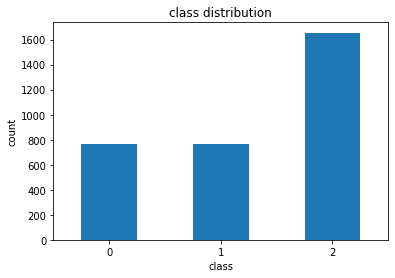

In [6]:
ax = data['class'].value_counts().sort_index().plot(kind='bar')
ax.set_title('class distribution')
ax.set_xlabel('class')
ax.set_ylabel('count')
ax.tick_params(rotation=0)

print('# features:', len(data['sequence'][0]), 'bp')

# Conv2d

In [19]:
word_size = 3
region_size = 0

encode_func = encode(word_size, region_size)
x_shape = encoded_shape(data['sequence'][0], word_size, region_size)

x, y = data['sequence'].to_numpy(), data['class'].to_numpy()
x = np.array([encode_func(_) for _ in x])
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

len(x_train), len(x_test)

(2392, 798)

In [20]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(8, 3, activation='relu', input_shape=x_shape),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(3, activation='softmax'),
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 62, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 31, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6944)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6944)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 55560     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 55,667
Trainable params: 55,667
Non-trainable params: 0
____________________________________________________

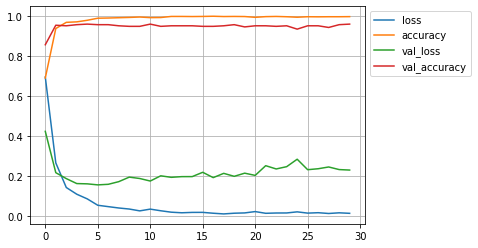

In [21]:
history = model.fit(x_train, y_train, epochs=30, validation_split=0.15, verbose=0)
ax = pd.DataFrame(history.history).plot()
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.grid()

In [22]:
model.evaluate(x_test, y_test, verbose=2)

25/25 - 0s - loss: 0.1649 - accuracy: 0.9586


[0.16492193937301636, 0.9586465954780579]

In [23]:
pd.DataFrame(history.history).to_csv('/content/drive/My Drive/dna-nn/UCI/splice-conv2D.csv', index=False)
model.save('/content/drive/My Drive/dna-nn/UCI/splice-conv2D.h5')

# Conv1D

In [12]:
encode_func = encode(word_size, region_size, expand=False)
x_shape = encoded_shape(data['sequence'][0], word_size, region_size, expand=False)

x, y = data['sequence'].to_numpy(), data['class'].to_numpy()
x = np.array([encode_func(_) for _ in x])
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

len(x_train), len(x_test)

(2392, 798)

In [13]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv1D(8, 3, activation='relu', input_shape=x_shape),
    keras.layers.MaxPooling1D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(3, activation='softmax'),
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 56, 8)             1544      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 28, 8)             0         
_________________________________________________________________
flatten (Flatten)            (None, 224)               0         
_________________________________________________________________
dropout (Dropout)            (None, 224)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 1800      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 3,371
Trainable params: 3,371
Non-trainable params: 0
______________________________________________________

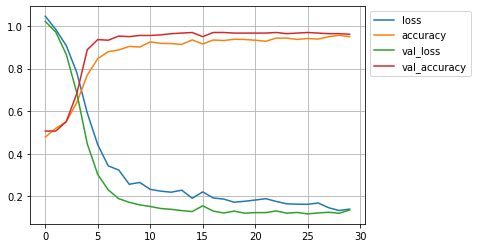

In [14]:
history = model.fit(x_train, y_train, epochs=30, validation_split=0.15, verbose=0)
ax = pd.DataFrame(history.history).plot()
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.grid()

In [16]:
model.evaluate(x_test, y_test, verbose=2)

25/25 - 0s - loss: 0.1547 - accuracy: 0.9612


[0.1547255963087082, 0.9611529111862183]

In [15]:
gpd.DataFrame(history.history).to_csv('/content/drive/My Drive/dna-nn/UCI/splice-conv1D.csv', index=False)
model.save('/content/drive/My Drive/dna-nn/UCI/splice-conv1D.h5')